In [1]:
from os import path, walk
from matplotlib import pyplot as plt
from matplotlib import patches
import random as rd
from tqdm import tqdm
import cv2 as cv
import numpy as np
import pandas as pd
from scipy import signal
from scipy import ndimage
import time

# custom lib
from inspect import getsourcefile
import os.path as path, sys
sys.path.insert(0, "..")
from alprLib.PlateBoundingBox import PlateBoundingBox
sys.path.pop(0)

'..'

# Load images data

#### EU dataset

In [2]:
DATASET_PATH = "../eu_dataset"
ANNOTATIONS_PATH = path.join(DATASET_PATH, "annots")
IMAGES_PATH = path.join(DATASET_PATH, "images")

In [3]:
raw_imgs = []
annotations = []
image_filenames = list(walk(IMAGES_PATH))
for image_filename in tqdm(image_filenames[0][2]):
    image_path = path.join(image_filenames[0][0], image_filename)
    annotation = image_filename.split('.')[0] + '.xml'
    annotation_path = path.join(ANNOTATIONS_PATH, annotation)
    plates = PlateBoundingBox.load_from_xml(xml_path=annotation_path)
    if len(plates) == 0:
        continue

    img = cv.imread(image_path)
    raw_imgs.append(img)
    annotations.append(plates[0])

  0%|          | 0/2245 [00:00<?, ?it/s]

100%|██████████| 2245/2245 [00:35<00:00, 63.49it/s]


#### Extract random image

Image: 163


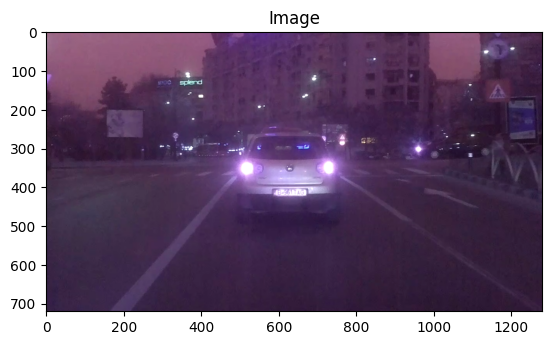

In [4]:
# Random image

random_index = rd.randint(0, len(raw_imgs) - 1)

# random_index = 48
# random_index = 426
random_index = 163

#random_index = 141
#random_index = 226

print(f"Image: {random_index}")

image = raw_imgs[random_index]
image_gray_src = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
image_gray_src = np.float32(image_gray_src)

plt.figure()
plt.title("Image")
plt.imshow(image, cmap="gray")


Image shape: (54, 121, 3)
max value: 255.0


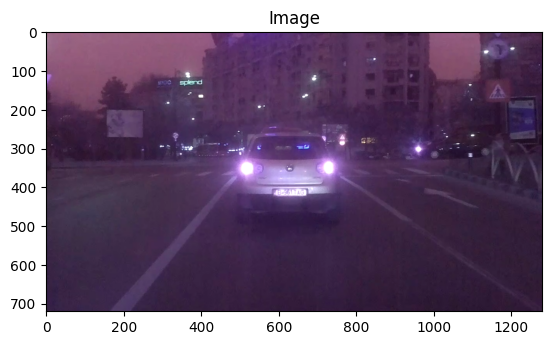

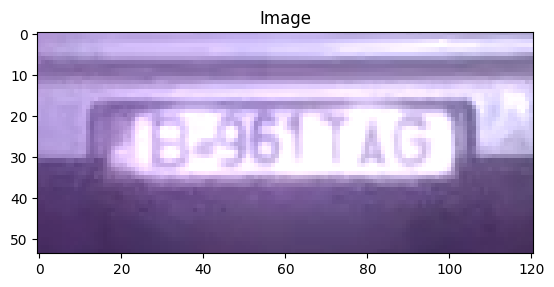

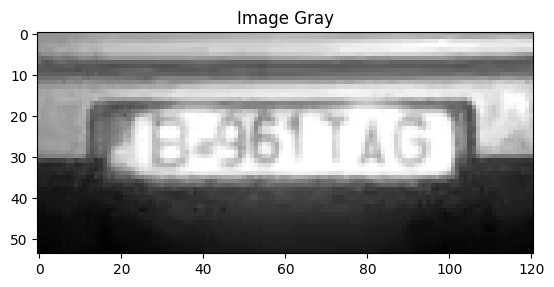

In [5]:

image_src = raw_imgs[random_index]
image_gray_src = cv.cvtColor(image_src,cv.COLOR_BGR2GRAY)
image_gray_src = np.float32(image_gray_src)

plt.figure()
plt.title("Image")
plt.imshow(image_src, cmap="gray")

padding = 15
plate = annotations[random_index]
xmin = plate.xmin-padding
ymin = plate.ymin-padding
xmax = plate.xmax+padding
ymax = plate.ymax+padding
image_gray_src = image_gray_src[ymin:ymax, xmin:xmax]
image_src = image_src[ymin:ymax, xmin:xmax]

print(f"Image shape: {image_src.shape}")
print(f"max value: {np.max(image_gray_src)}")

plt.figure()
plt.title("Image")
plt.imshow(image_src, cmap="gray")
plt.figure()
plt.title("Image Gray")
plt.imshow(image_gray_src, cmap="gray")


In [6]:
def kmean_segmentation(img, n_iterations = 5, n_classes = 10):
  # Initial classes centers
  max_val = np.max(img)
  min_val = np.min(img)
  interval = float(max_val-min_val)/n_classes
  classes_center = np.array([ interval/2 + min_val + interval*i for i in range(n_classes) ])

  classification = np.zeros(img.shape)
  classes_pixel_values = []
  for i in range(n_iterations):
    # Update pixel classes
    classes_pixel_values = [[] for i in range(n_classes)]
    for l in range(0, img.shape[0]):
      for c in range(0, img.shape[1]):
        dist_to_classes = np.abs(classes_center-img[l,c])
        class_index = np.argmin(dist_to_classes)
        classes_pixel_values[class_index].append(img[l,c])
        classification[l,c] = class_index

    # Update class centers
    for i in range(n_classes):
      center = np.mean(np.array(classes_pixel_values[i]))
      classes_center[i] = center

  return classification, classes_center

# Method based on whiteness

(54, 121)


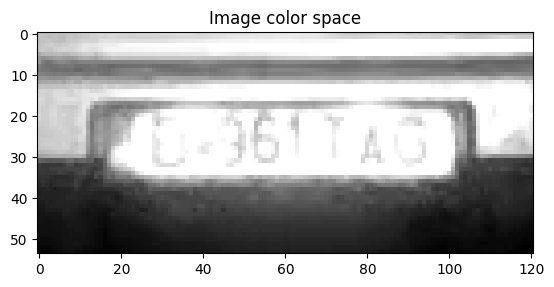

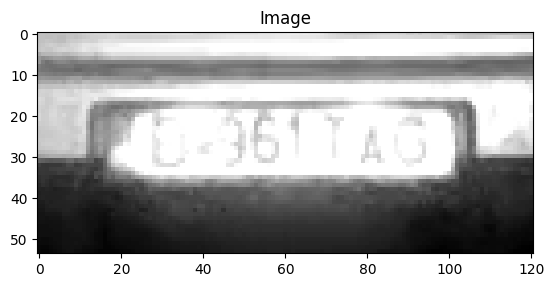

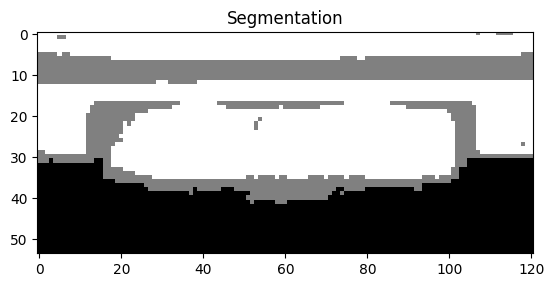

In [7]:
image_gray = cv.cvtColor(image_src, cv.COLOR_BGR2HSV)[:,:,2]
print(image_gray.shape)
plt.figure()
plt.title("Image color space")
plt.imshow(image_gray, cmap="gray")

# image_gray = np.copy(image_gray_src)

# Smooth the image
# image_blur = cv.GaussianBlur(image_gray, ksize=(3, 3), sigmaX=0)
# Histogram equalization to has better constrast
# image_gray = cv.equalizeHist(np.uint8(image_blur))
# clahe = cv.createCLAHE(clipLimit=40.0, tileGridSize=(4,4))
# image_gray = clahe.apply(np.uint8(image_blur))

# Classify based on color
# The brightess color is the last class
classes_count = 3
seg, _ = kmean_segmentation(image_gray, 10, classes_count)

# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# K = 3
# Z = image.reshape((-1,3))
# Z = np.float32(Z)
# ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
# center = np.uint8(center)
# res = center[label.flatten()]
# seg3 = res.reshape((image.shape))

# print(seg3[23,50,0])
# print(seg3[23,50,1])
# print(seg3[23,50,2])

# plt.figure()
# plt.title("Segmentation")
# plt.imshow(seg3[:,:,0], cmap="gray")

# plt.figure()
# plt.title("Segmentation")
# plt.imshow(seg3[:,:,1], cmap="gray")

# plt.figure()
# plt.title("Segmentation")
# plt.imshow(seg3[:,:,2], cmap="gray")

seg = np.uint8(seg)

plt.figure()
plt.title("Image")
plt.imshow(image_gray, cmap="gray")

plt.figure()
plt.title("Segmentation")
plt.imshow(seg, cmap="gray")


center: [27.  60.5]
class 0 mean dist: 82951.05377774546
class 1 mean dist: 48496.83113292888
class 2 mean dist: 97035.12742277379


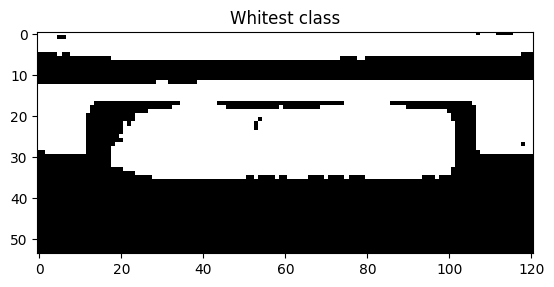

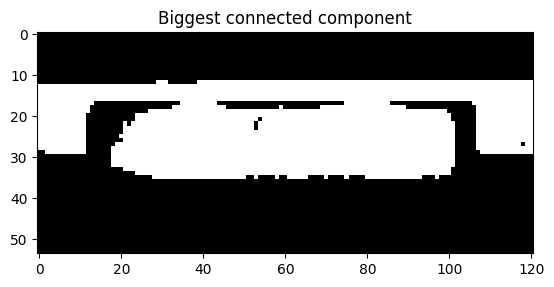

In [8]:

classes_dist = []
img_center = np.array([seg.shape[0]/2, seg.shape[1]/2])
print(f"center: {img_center}")
for i in range(classes_count):
  pixels_to_center = np.transpose(np.nonzero(seg==i)) - img_center
  pixels_to_center_dist = np.linalg.norm(pixels_to_center, axis=1)
  mean_dist = np.sum(pixels_to_center_dist)
  classes_dist.append(mean_dist)
  print(f"class {i} mean dist: { mean_dist }")

# Get the class closest to the center
seg_class = np.argmin(np.array([
  d for i, d in enumerate(classes_dist)
]))

# class0 = np.uint8(1*(seg==seg_class))
class0 = np.uint8(1*(seg==2))
# Extract connected components of that class
ret, comps = cv.connectedComponents(class0)
# Get the size of the components
colors, counts = np.unique(
  comps.reshape(-1), return_counts = True, axis = 0
  )
colors = np.delete(colors, 0) # Remove background component
counts = np.delete(counts, 0) # Remove background component
# Get the biggest component
compMax = comps==colors[np.argmax(counts)]
compMax = np.uint8(compMax)

plt.figure()
plt.title("Whitest class")
plt.imshow(class0, cmap='gray')

plt.figure()
plt.title("Biggest connected component")
# plt.imshow(comps==colors[np.argmax(counts)], cmap="gray")
plt.imshow(compMax, cmap="gray")

# We are left with a single connected 
# component that should be most parts of the plate
seg = compMax


[[-7.0417195e-16  1.2000000e+01]
 [ 1.2000000e+02  1.2000000e+01]
 [ 1.2000000e+02  3.5000000e+01]
 [ 0.0000000e+00  3.5000000e+01]]
A:: 0


/tmp/ipykernel_10468/278153365.py:25: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(255),2)


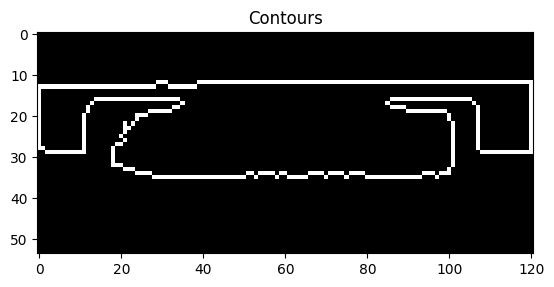

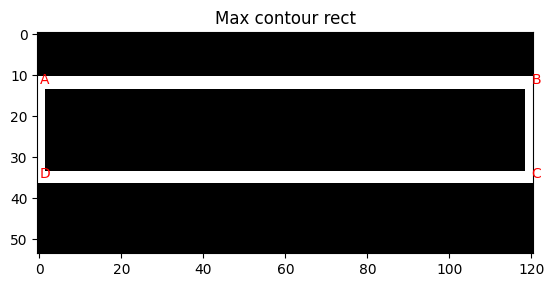

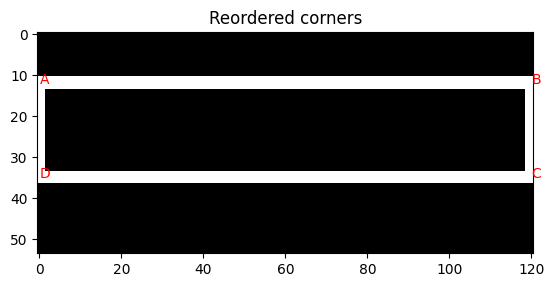

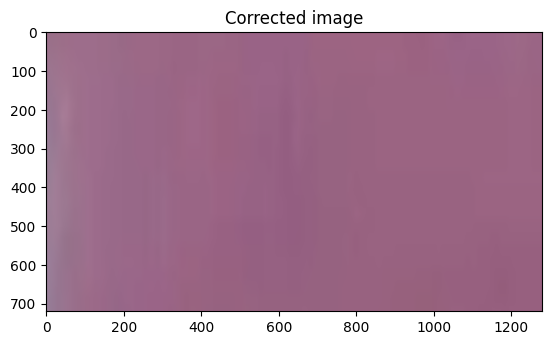

In [9]:

# Detect contours
contours, _= cv.findContours(
    seg, 
    mode=cv.RETR_EXTERNAL, # We should get a single contours for the single connected component
    method=cv.CHAIN_APPROX_SIMPLE
)
image_contours = np.zeros(image_gray.shape, dtype=np.uint8)
cv.drawContours(image_contours, contours=contours, contourIdx=-1, color=(255, 255, 255))
plt.figure()
plt.title("Contours")
plt.imshow(image_contours, cmap="gray")

# Find biggest contour
max_area_contour = contours[0]
max_area = cv.contourArea(max_area_contour)
for contour in contours:
  area = cv.contourArea(contour)
  if area > max_area:
    max_area = area
    max_area_contour = contour

image_polycontours_best = np.zeros(image_gray.shape, dtype=np.uint8)
rect = cv.minAreaRect(max_area_contour)
corners = cv.boxPoints(rect)
cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(255),2)
plt.figure()
plt.title("Max contour rect")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r")
plt.text(corners[1,0],corners[1,1], "B", c="r")
plt.text(corners[2,0],corners[2,1], "C", c="r")
plt.text(corners[3,0],corners[3,1], "D", c="r")
print(corners)

Aind = np.argmin(np.linalg.norm(corners-np.zeros(corners.shape), axis=1))
print(f"A:: {Aind}")
corners = np.array([ corners[(i+Aind)%4] for i in range(4)])
plt.figure()
plt.title("Reordered corners")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r")
plt.text(corners[1,0],corners[1,1], "B", c="r")
plt.text(corners[2,0],corners[2,1], "C", c="r")
plt.text(corners[3,0],corners[3,1], "D", c="r")

out_height = image.shape[0]
out_width = image.shape[1]
output_size = (out_width, out_height)
perspective_matrix = cv.getPerspectiveTransform(
  corners,
  np.array([
      [0, 0], [out_width, 0],
      [out_width, out_height], [0, out_height]
    ], dtype=np.float32)
  )
corrected_image = cv.warpPerspective(
  image, perspective_matrix, output_size, cv.WARP_INVERSE_MAP
  )

plt.figure()
plt.title("Corrected image")
plt.imshow(corrected_image, cmap="gray")


# Method based on color super pixel

/home/barth/.pyenv/versions/3.9.16/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/barth/.pyenv/versions/3.9.16/lib/python3.9/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


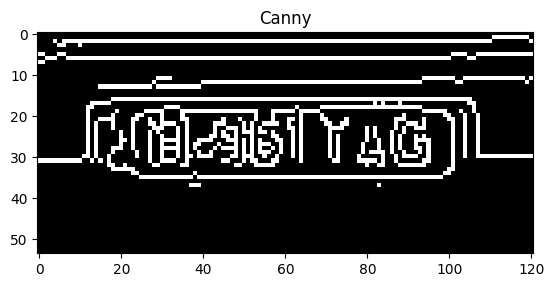

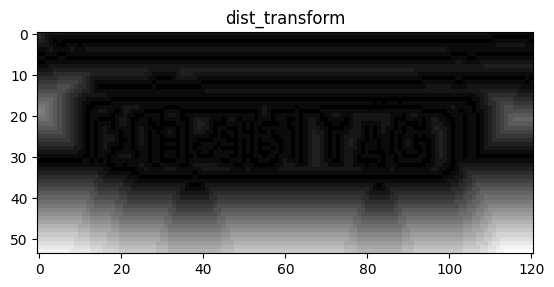

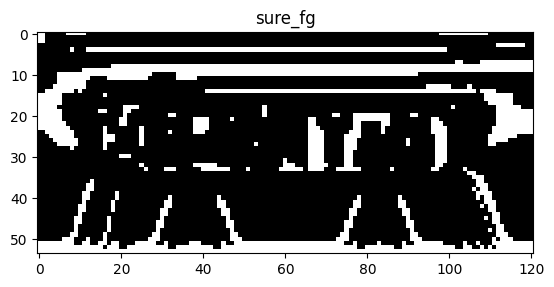

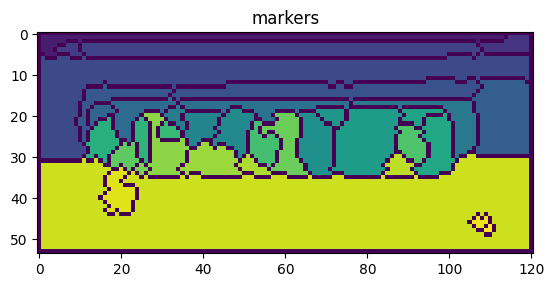

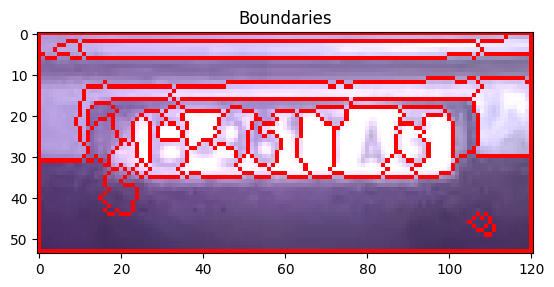

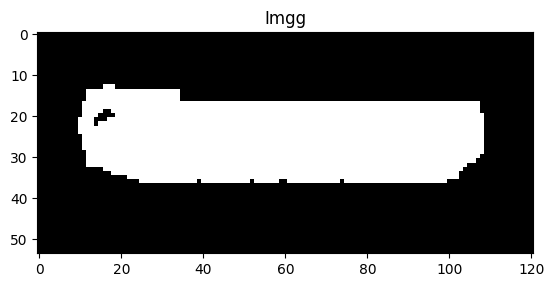

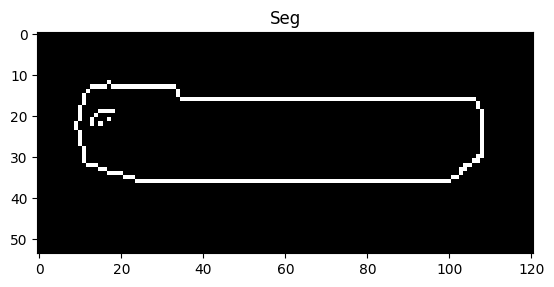

In [10]:


image_gray = np.uint8(image_gray_src)
# image_gray = cv.medianBlur(image_gray, ksize=3)
# image_gray = cv.equalizeHist(image_gray)
# image_gray = cv.GaussianBlur(image_gray, ksize=(3, 3), sigmaX=0.1)
image_gray = np.uint8(image_gray)


# imageRGB = np.float32(image_src)
# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# ret,label,center=cv.kmeans(imageRGB,100,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
# center = np.uint8(center)
# res = center[label.flatten()]
# imageRGB = res.reshape((imageRGB.shape))

# plt.figure()
# plt.title("Image")
# plt.imshow(imageRGB)

seg = cv.Canny(image_gray,50,200)
plt.figure()
plt.title("Canny")
plt.imshow(seg, cmap="gray")

segg = np.bitwise_not(seg)
dist_transform = cv.distanceTransform(segg,cv.DIST_L2,5)
dist_transform = np.uint8(dist_transform)
sure_fg = cv.adaptiveThreshold(
  dist_transform,
  maxValue=dist_transform.max(),
  adaptiveMethod=cv.ADAPTIVE_THRESH_MEAN_C,
  thresholdType=cv.THRESH_BINARY,
  blockSize=11,
  C=0
)

sure_fg = np.uint8(sure_fg)

ret, markers = cv.connectedComponents(sure_fg)
markers = markers+1
markers[sure_fg==0] = 0

markers = cv.watershed(image_src,markers)
img = np.copy(image_src)
img[markers == -1] = [255,0,0]

# Red - Blue - Green
main_color = np.array([200,200,200])
mas_color_dist = 150

seg_ave = []
imgg = np.zeros(image_gray.shape)
for i in range(ret):
  c = np.mean(img[markers==i+1], axis=0)
  pixelCenter = np.mean(np.argwhere(markers==i+1), axis=0)
  d = np.linalg.norm(main_color-c)
  if d<mas_color_dist and (
    pixelCenter[0]>padding and pixelCenter[0]<image_gray.shape[0]-padding and
    pixelCenter[1]>padding and pixelCenter[1]<image_gray.shape[1]-padding
  ):
    imgg[markers==i+1] = 255
kernel = np.ones((2,2),np.uint8)
imgg = cv.dilate(imgg, kernel, iterations=2)

imgg = np.uint8(imgg)
m = np.max(imgg)
seg = cv.Canny(imgg,0.1*m,0.3*m)

# kernel = np.ones((2,2),np.uint8)
# seg = cv.dilate(seg, kernel, iterations=1)
# seg = cv.erode(seg, kernel, iterations=1)

plt.figure()
plt.title("dist_transform")
plt.imshow(dist_transform, cmap="gray")
plt.figure()
plt.title("sure_fg")
plt.imshow(sure_fg, cmap="gray")
plt.figure()
plt.title("markers")
plt.imshow(markers)

plt.figure()
plt.title("Boundaries")
plt.imshow(img)

plt.figure()
plt.title("Imgg")
plt.imshow(imgg, cmap='gray')

plt.figure()
plt.title("Seg")
plt.imshow(seg, cmap='gray')



[[[ 10  21]]

 [[107  17]]

 [[108  29]]

 [[ 25  36]]]
[[ 10  21]
 [107  17]
 [108  29]
 [ 25  36]]
A:: 0


/tmp/ipykernel_10468/1680113187.py:52: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(imag,[np.int0(contour)],0,(0,255,0),1)
/tmp/ipykernel_10468/1680113187.py:53: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(imag,[np.int0(conv)],0,(0,0,255),1)
/tmp/ipykernel_10468/1680113187.py:54: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(imag,[np.int0(approx)],0,(255,0,0),1)
/tmp/ipykernel_10468/1680113187.py:55: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(imag,[np.int0(cc)],0,(255,255,0),1)
/tmp/ipykernel_10468/1680113187.py:71: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(0,255,0),1)


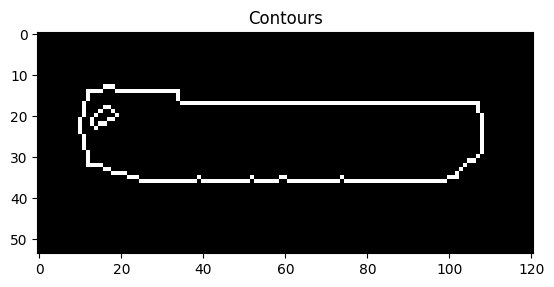

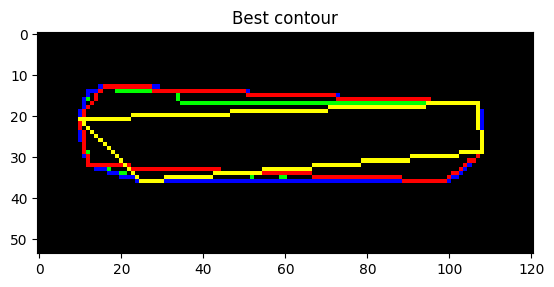

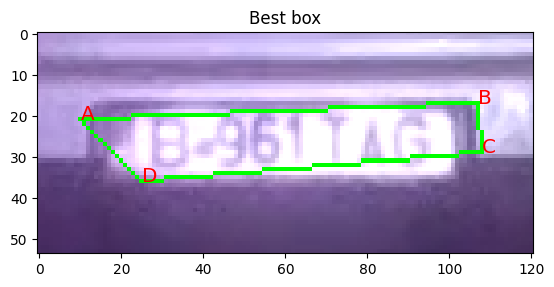

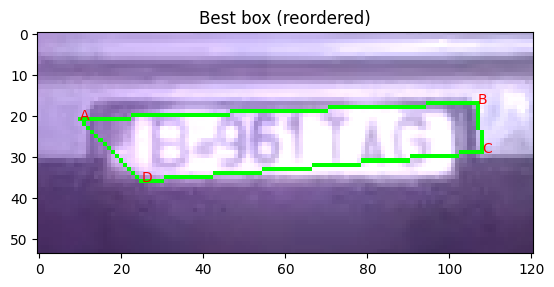

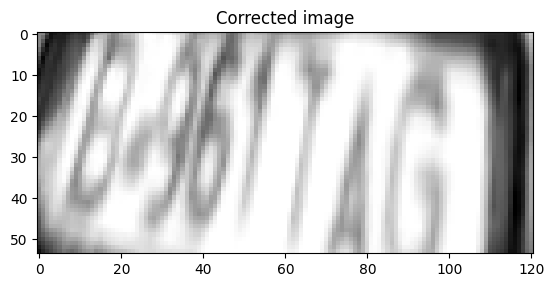

In [11]:

# Detect contours
imgg = np.uint8(imgg)
contours, _= cv.findContours(
    imgg, 
    # mode=cv.RETR_EXTERNAL,
    mode=cv.RETR_LIST,
    method=cv.CHAIN_APPROX_NONE
)
image_contours = np.zeros(image_gray.shape, dtype=np.uint8)
cv.drawContours(image_contours, contours=contours, contourIdx=-1, color=(255, 255, 255))
plt.figure()
plt.title("Contours")
plt.imshow(image_contours, cmap="gray")

# Find biggest contour
best_contour = contours[0]
best_contour_weight = np.inf
total_area = image_gray.shape[0]*image_gray.shape[1]
for contour in contours:
    epsilon = np.min([image_gray.shape[0],image_gray.shape[1]])*0.1
    approx = cv.approxPolyDP(contour,epsilon,True)
    conv = cv.convexHull(contour)
    box = cv.minAreaRect(best_contour)
    box = cv.boxPoints(box)

    contourArea = cv.contourArea(contour)
    approxArea = cv.contourArea(approx)
    convArea = cv.contourArea(conv)
    boxArea = cv.contourArea(box)
    if contourArea>0:
        weight0 = approxArea/contourArea
        weight1 = convArea/contourArea
        weight2 = convArea/total_area
    else:
        weight0 = 0
        weight1 = 0
        weight2 = 0

    if weight0>0 and weight1>0 and weight2>0:
      weight = abs(weight0-weight1)/(weight2)
    else:
      weight = np.inf

    cc = cv.approxPolyDP(conv,0.04*cv.arcLength(conv, closed=True),True)
    if weight < best_contour_weight:
      best_contour_weight = weight
      best_contour = cc

      # Little display
      imag = np.zeros(image_gray.shape, dtype=np.uint8)
      imag = cv.cvtColor(imag, cv.COLOR_GRAY2BGR)
      cv.drawContours(imag,[np.int0(contour)],0,(0,255,0),1)
      cv.drawContours(imag,[np.int0(conv)],0,(0,0,255),1)
      cv.drawContours(imag,[np.int0(approx)],0,(255,0,0),1)
      cv.drawContours(imag,[np.int0(cc)],0,(255,255,0),1)
      plt.figure()
      plt.title("Best contour")
      # plt.title(f"{weight0}  {weight1}  {weight2}")
      plt.imshow(imag)

image_polycontours_best = np.copy(image_src)
print(best_contour)
corners = np.array([
  best_contour[0,0],
  best_contour[1,0],
  best_contour[2,0],
  best_contour[3,0]
])
# rect = cv.minAreaRect(best_contour)
# corners = cv.boxPoints(rect)
cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(0,255,0),1)
plt.figure()
plt.title("Best box")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r", size='x-large')
plt.text(corners[1,0],corners[1,1], "B", c="r", size='x-large')
plt.text(corners[2,0],corners[2,1], "C", c="r", size='x-large')
plt.text(corners[3,0],corners[3,1], "D", c="r", size='x-large')
print(corners)

Aind = np.argmin(np.linalg.norm(corners-np.zeros(corners.shape), axis=1))
print(f"A:: {Aind}")
corners = np.array([ corners[(i+Aind)%4] for i in range(4)])
corners = np.float32(corners)
plt.figure()
plt.title("Best box (reordered)")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r")
plt.text(corners[1,0],corners[1,1], "B", c="r")
plt.text(corners[2,0],corners[2,1], "C", c="r")
plt.text(corners[3,0],corners[3,1], "D", c="r")

out_height = image_gray.shape[0]
out_width = image_gray.shape[1]
output_size = (out_width, out_height)
perspective_matrix = cv.getPerspectiveTransform(
  corners,
  np.array([
      [0, 0], [out_width, 0],
      [out_width, out_height], [0, out_height]
    ], dtype=np.float32)
  )
corrected_image = cv.warpPerspective(
  image_gray, perspective_matrix, output_size, cv.WARP_INVERSE_MAP
  )

plt.figure()
plt.title("Corrected image")
plt.imshow(corrected_image, cmap="gray")


# Method based on edge detection

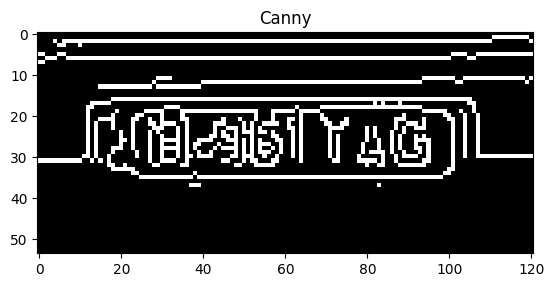

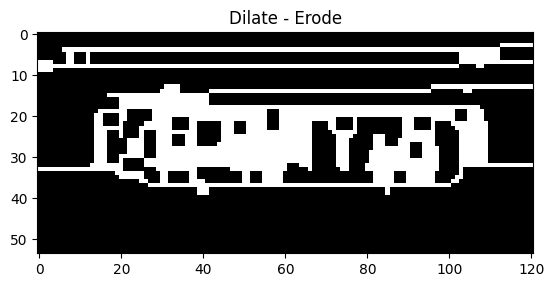

In [12]:


image_gray = np.uint8(image_gray_src)
# image_gray = cv.medianBlur(image_gray, ksize=3)
# image_gray = cv.equalizeHist(image_gray)
# image_gray = cv.GaussianBlur(image_gray, ksize=(3, 3), sigmaX=0.1)
image_gray = np.uint8(image_gray)


# imageRGB = np.float32(image_src)
# criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# ret,label,center=cv.kmeans(imageRGB,100,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
# center = np.uint8(center)
# res = center[label.flatten()]
# imageRGB = res.reshape((imageRGB.shape))

# plt.figure()
# plt.title("Image")
# plt.imshow(imageRGB)

seg = cv.Canny(image_gray,50,200)

plt.figure()
plt.title("Canny")
plt.imshow(seg, cmap="gray")

# Try to close edges
kernel = np.ones((2,2),np.uint8)
seg = cv.dilate(seg, kernel, iterations=2)
seg = cv.erode(seg, kernel, iterations=2)

plt.figure()
plt.title("Dilate - Erode")
plt.imshow(seg, cmap="gray")


[[[120  13]]

 [[120  32]]

 [[  0  33]]

 [[ 17  15]]]
[[120  13]
 [120  32]
 [  0  33]
 [ 17  15]]
A:: 3


/tmp/ipykernel_10468/2284518493.py:52: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(imag,[np.int0(contour)],0,(0,255,0),1)
/tmp/ipykernel_10468/2284518493.py:53: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(imag,[np.int0(conv)],0,(0,0,255),1)
/tmp/ipykernel_10468/2284518493.py:54: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(imag,[np.int0(approx)],0,(255,0,0),1)
/tmp/ipykernel_10468/2284518493.py:55: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(imag,[np.int0(cc)],0,(255,255,0),1)
/tmp/ipykernel_10468/2284518493.py:71: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(0,255,0),1)


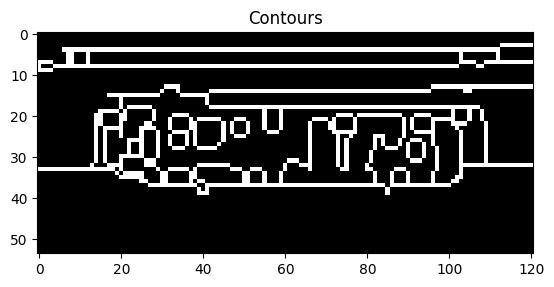

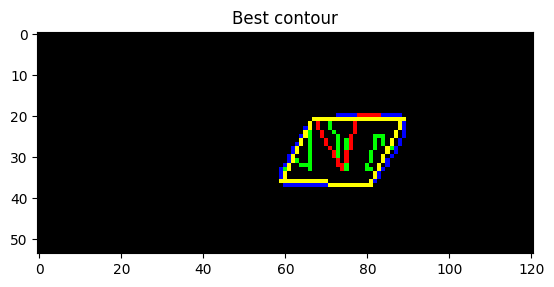

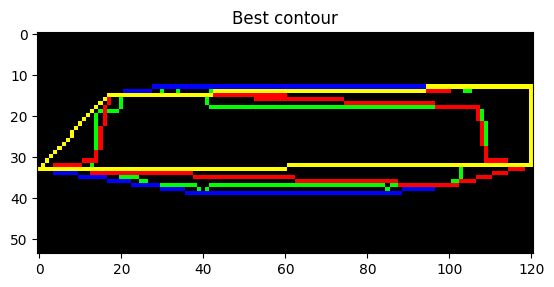

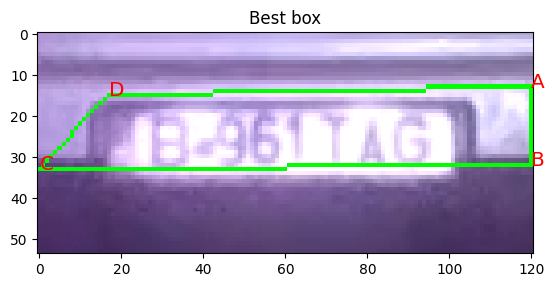

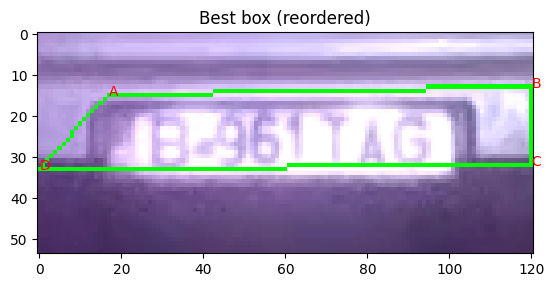

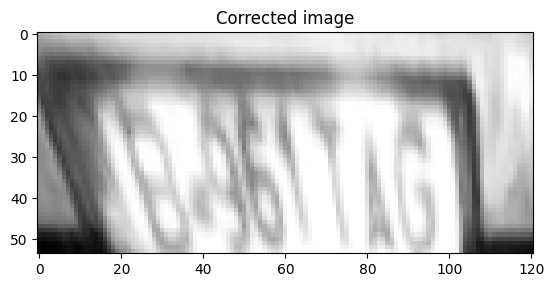

In [13]:

# Detect contours
seg = np.uint8(seg)
contours, _= cv.findContours(
    seg, 
    # mode=cv.RETR_EXTERNAL,
    mode=cv.RETR_LIST,
    method=cv.CHAIN_APPROX_NONE
)
image_contours = np.zeros(image_gray.shape, dtype=np.uint8)
cv.drawContours(image_contours, contours=contours, contourIdx=-1, color=(255, 255, 255))
plt.figure()
plt.title("Contours")
plt.imshow(image_contours, cmap="gray")

# Find biggest contour
best_contour = contours[0]
best_contour_weight = np.inf
total_area = image_gray.shape[0]*image_gray.shape[1]
for contour in contours:
    epsilon = np.min([image_gray.shape[0],image_gray.shape[1]])*0.1
    approx = cv.approxPolyDP(contour,epsilon,True)
    conv = cv.convexHull(contour)
    box = cv.minAreaRect(best_contour)
    box = cv.boxPoints(box)

    contourArea = cv.contourArea(contour)
    approxArea = cv.contourArea(approx)
    convArea = cv.contourArea(conv)
    boxArea = cv.contourArea(box)
    if contourArea>0:
        weight0 = approxArea/contourArea
        weight1 = convArea/contourArea
        weight2 = convArea/total_area
    else:
        weight0 = 0
        weight1 = 0
        weight2 = 0

    if weight0>0 and weight1>0 and weight2>0:
      weight = abs(weight0-weight1)/(weight2)
    else:
      weight = np.inf

    cc = cv.approxPolyDP(conv,0.04*cv.arcLength(conv, closed=True),True)
    if weight < best_contour_weight:
      best_contour_weight = weight
      best_contour = cc

      # Little display
      imag = np.zeros(image_gray.shape, dtype=np.uint8)
      imag = cv.cvtColor(imag, cv.COLOR_GRAY2BGR)
      cv.drawContours(imag,[np.int0(contour)],0,(0,255,0),1)
      cv.drawContours(imag,[np.int0(conv)],0,(0,0,255),1)
      cv.drawContours(imag,[np.int0(approx)],0,(255,0,0),1)
      cv.drawContours(imag,[np.int0(cc)],0,(255,255,0),1)
      plt.figure()
      plt.title("Best contour")
      # plt.title(f"{weight0}  {weight1}  {weight2}")
      plt.imshow(imag)

image_polycontours_best = np.copy(image_src)
print(best_contour)
corners = np.array([
  best_contour[0,0],
  best_contour[1,0],
  best_contour[2,0],
  best_contour[3,0]
])
# rect = cv.minAreaRect(best_contour)
# corners = cv.boxPoints(rect)
cv.drawContours(image_polycontours_best,[np.int0(corners)],0,(0,255,0),1)
plt.figure()
plt.title("Best box")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r", size='x-large')
plt.text(corners[1,0],corners[1,1], "B", c="r", size='x-large')
plt.text(corners[2,0],corners[2,1], "C", c="r", size='x-large')
plt.text(corners[3,0],corners[3,1], "D", c="r", size='x-large')
print(corners)

Aind = np.argmin(np.linalg.norm(corners-np.zeros(corners.shape), axis=1))
print(f"A:: {Aind}")
corners = np.array([ corners[(i+Aind)%4] for i in range(4)])
corners = np.float32(corners)
plt.figure()
plt.title("Best box (reordered)")
plt.imshow(image_polycontours_best, cmap="gray")
plt.text(corners[0,0],corners[0,1], "A", c="r")
plt.text(corners[1,0],corners[1,1], "B", c="r")
plt.text(corners[2,0],corners[2,1], "C", c="r")
plt.text(corners[3,0],corners[3,1], "D", c="r")

out_height = image_gray.shape[0]
out_width = image_gray.shape[1]
output_size = (out_width, out_height)
perspective_matrix = cv.getPerspectiveTransform(
  corners,
  np.array([
      [0, 0], [out_width, 0],
      [out_width, out_height], [0, out_height]
    ], dtype=np.float32)
  )
corrected_image = cv.warpPerspective(
  image_gray, perspective_matrix, output_size, cv.WARP_INVERSE_MAP
  )

plt.figure()
plt.title("Corrected image")
plt.imshow(corrected_image, cmap="gray")


# Final testing

image 1822: 0.0017609596252441406 seconds
image 1997: 0.0012738704681396484 seconds
image 916: 0.0014998912811279297 seconds
image 782: 0.0015041828155517578 seconds
image 821: 0.0018649101257324219 seconds
image 540: 0.0013158321380615234 seconds
image 545: 0.0012793540954589844 seconds
image 1252: 0.0014083385467529297 seconds
image 531: 0.002643108367919922 seconds
image 1075: 0.0016307830810546875 seconds
image 1279: 0.002628803253173828 seconds
image 2164: 0.0013489723205566406 seconds
image 2015: 0.001508951187133789 seconds
image 185: 0.0014438629150390625 seconds
image 1670: 0.0016717910766601562 seconds
image 1602: 0.0013580322265625 seconds
image 1030: 0.001207590103149414 seconds
image 698: 0.0013017654418945312 seconds
image 80: 0.0015306472778320312 seconds
image 427: 0.0018610954284667969 seconds


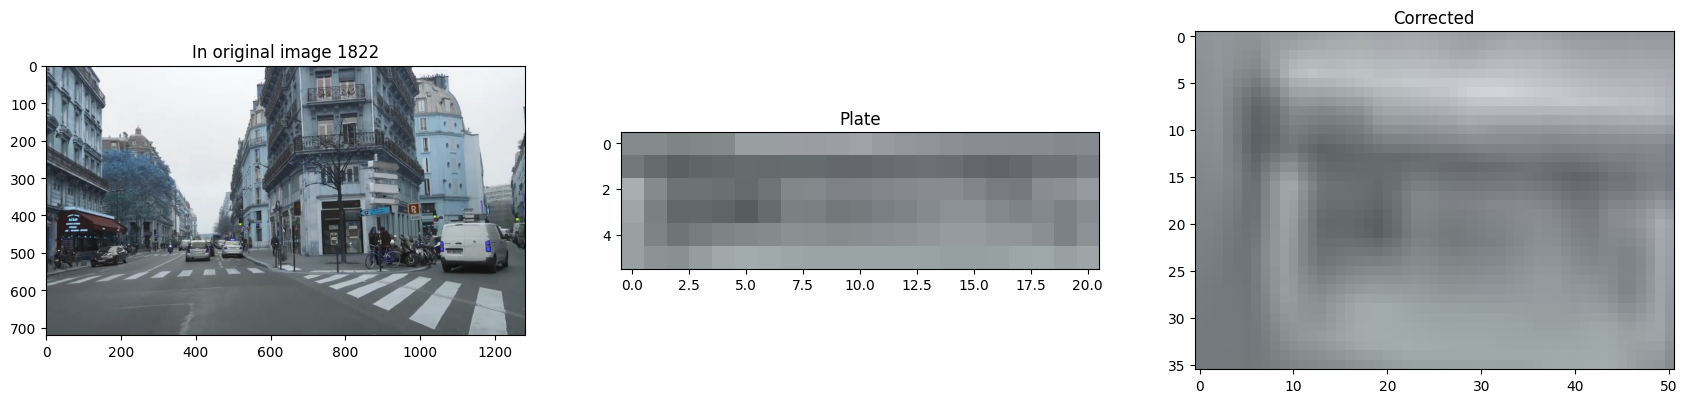

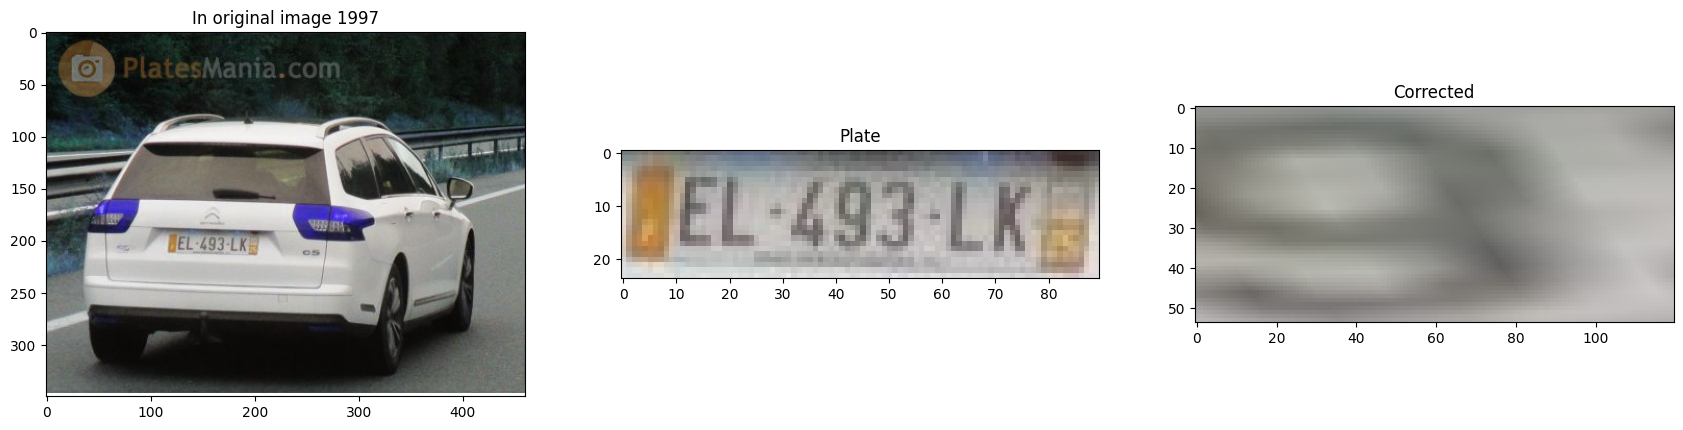

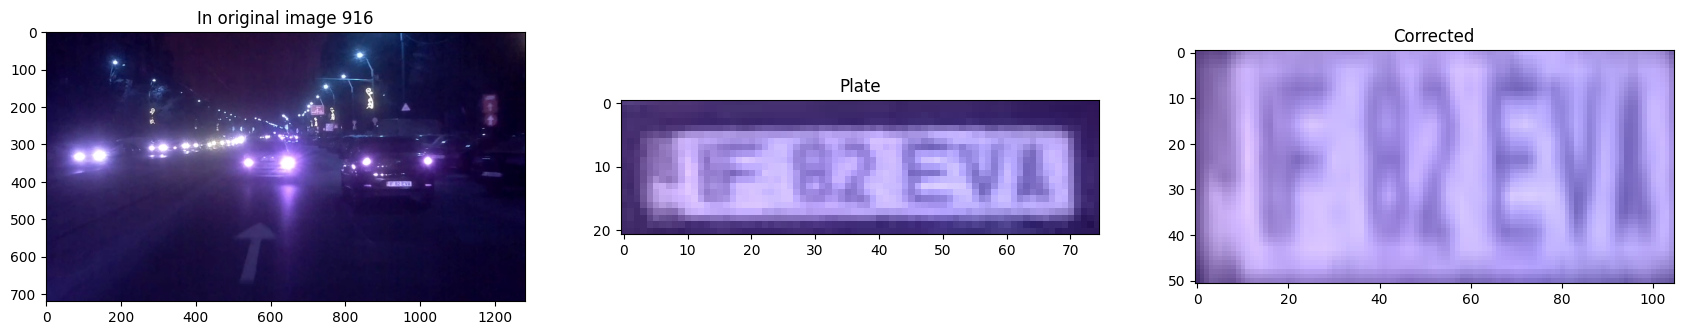

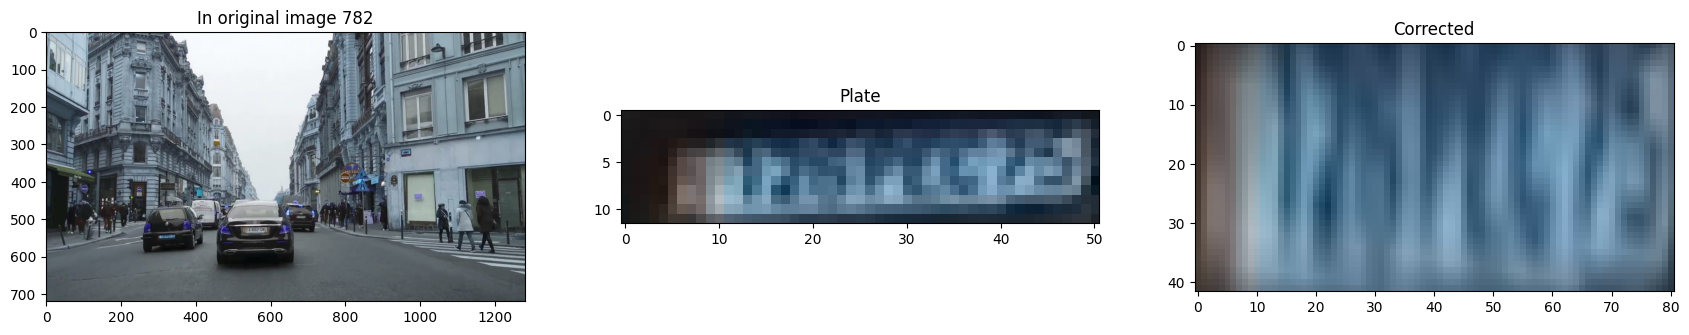

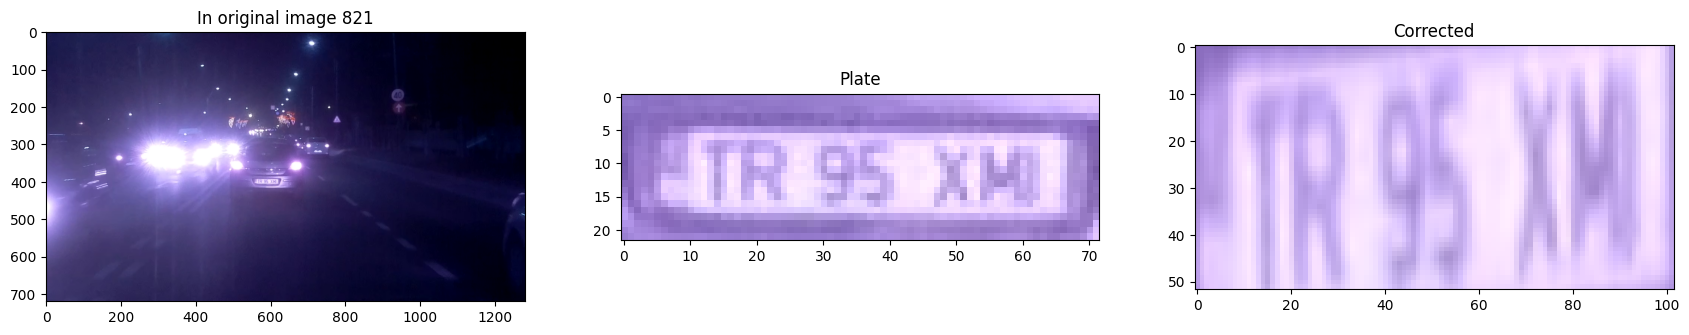

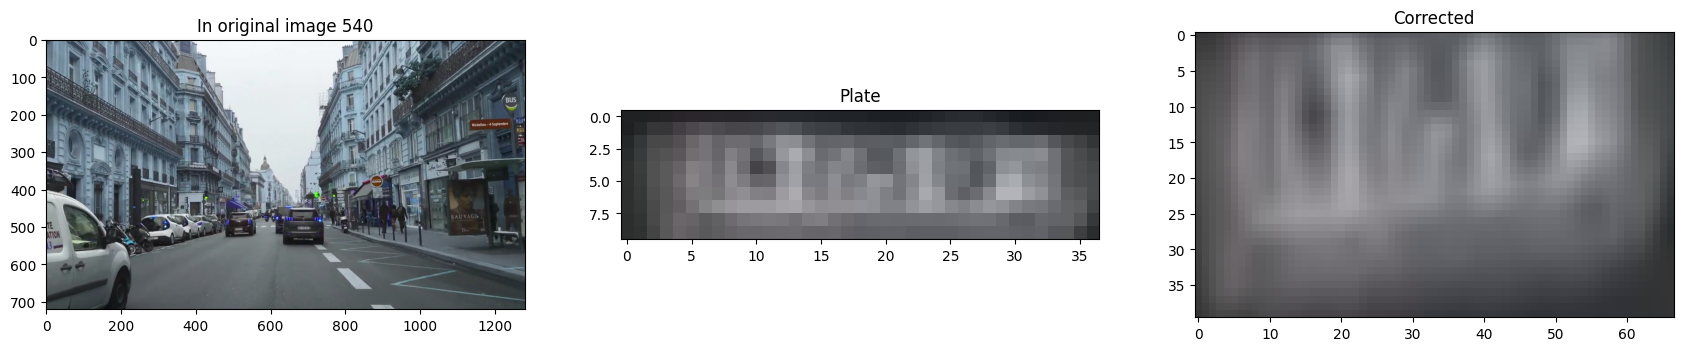

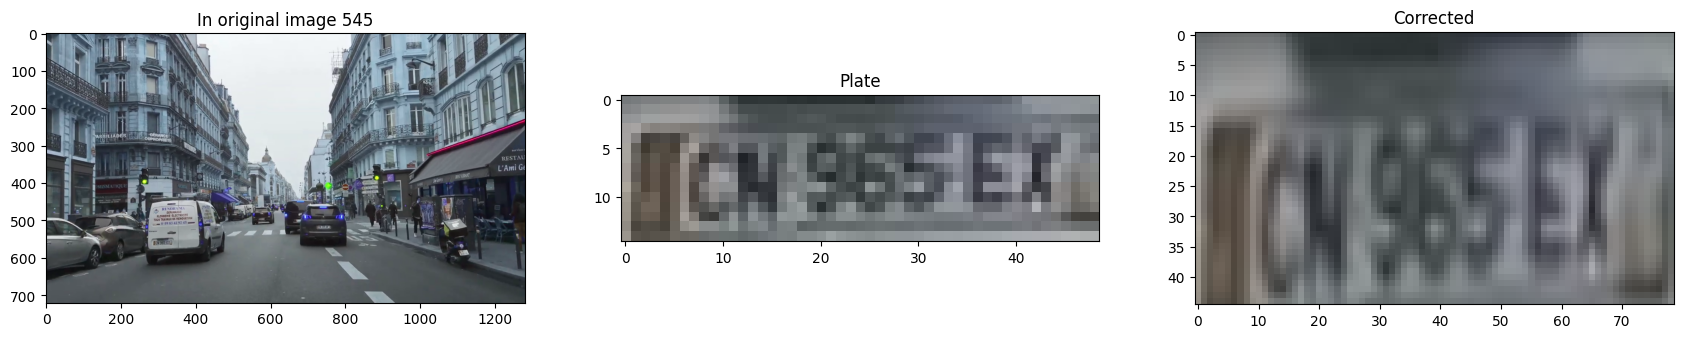

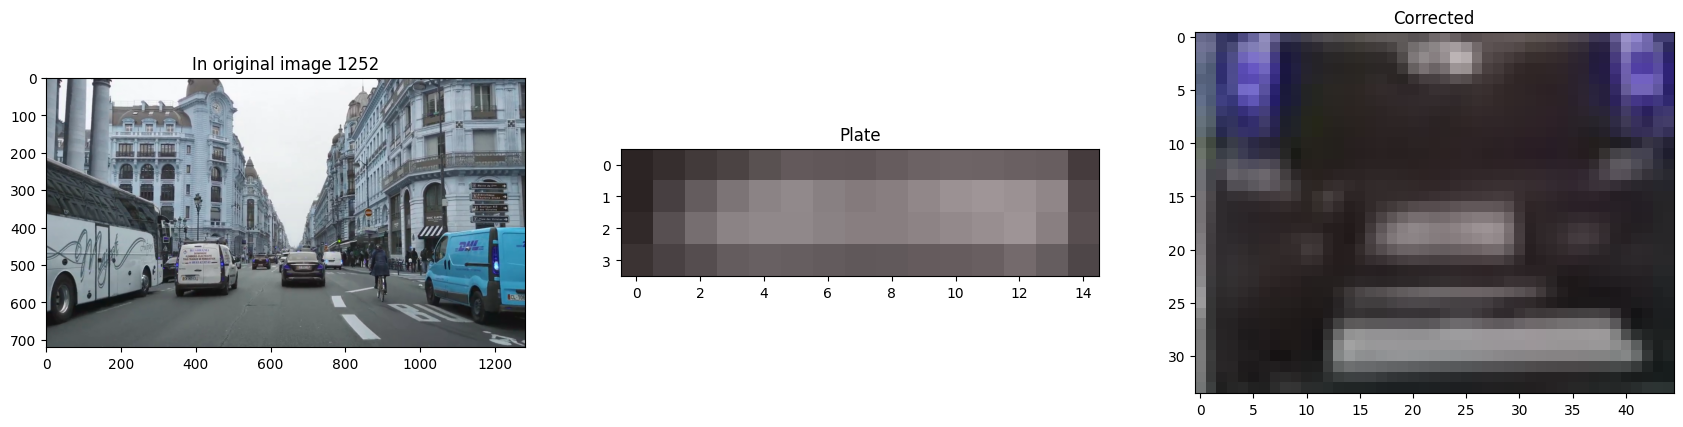

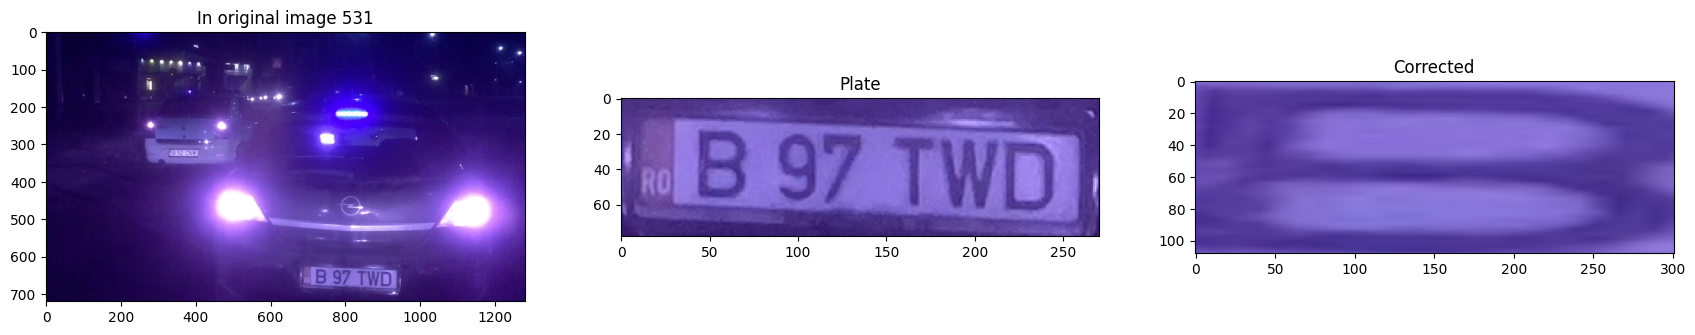

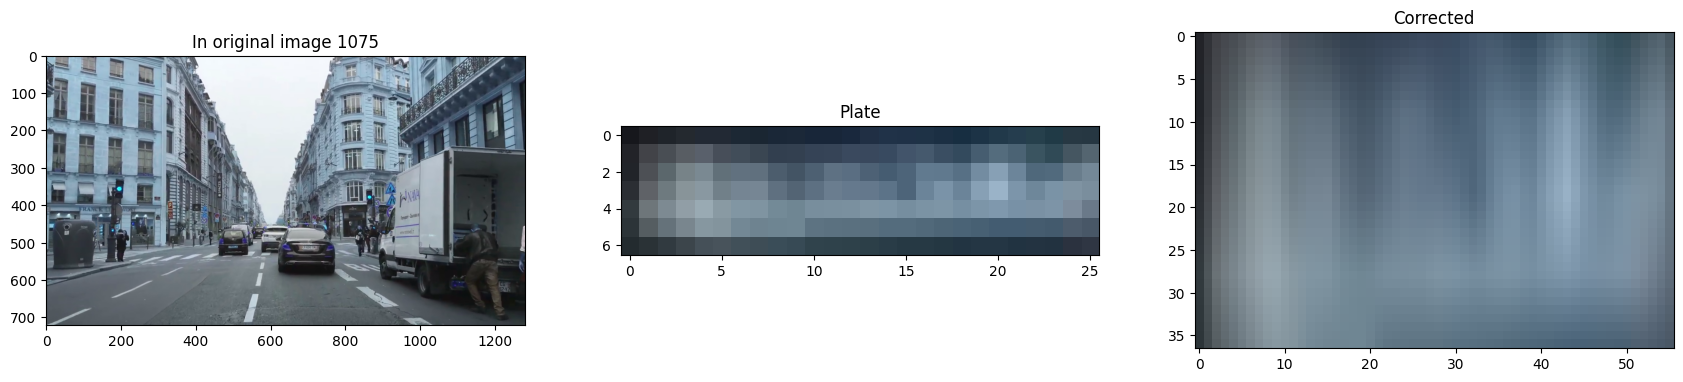

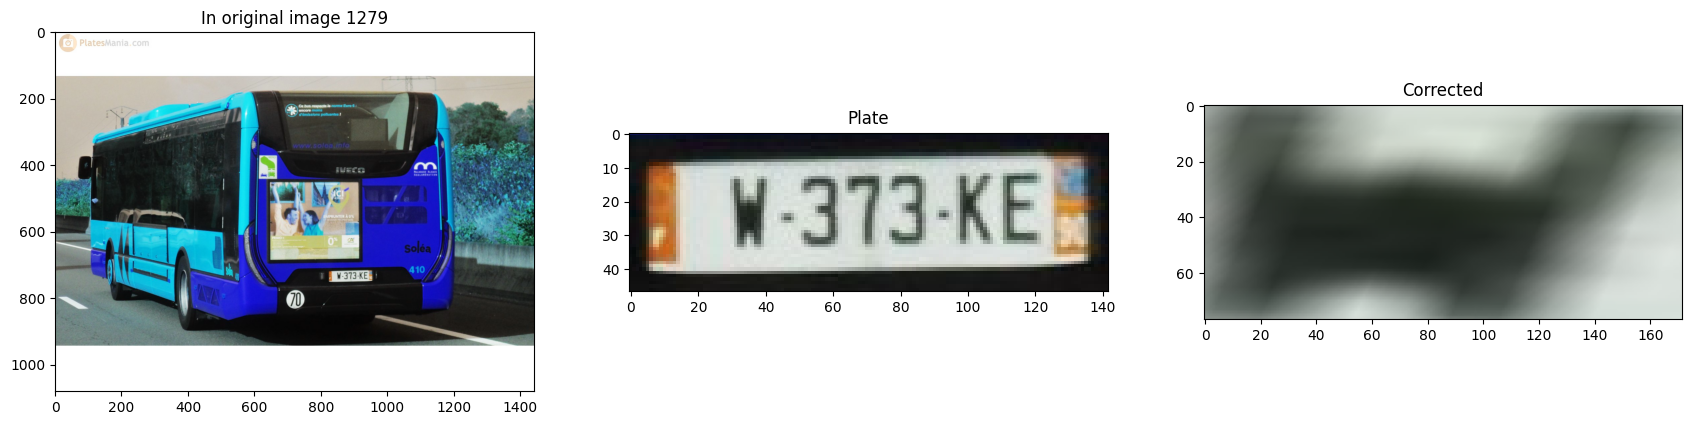

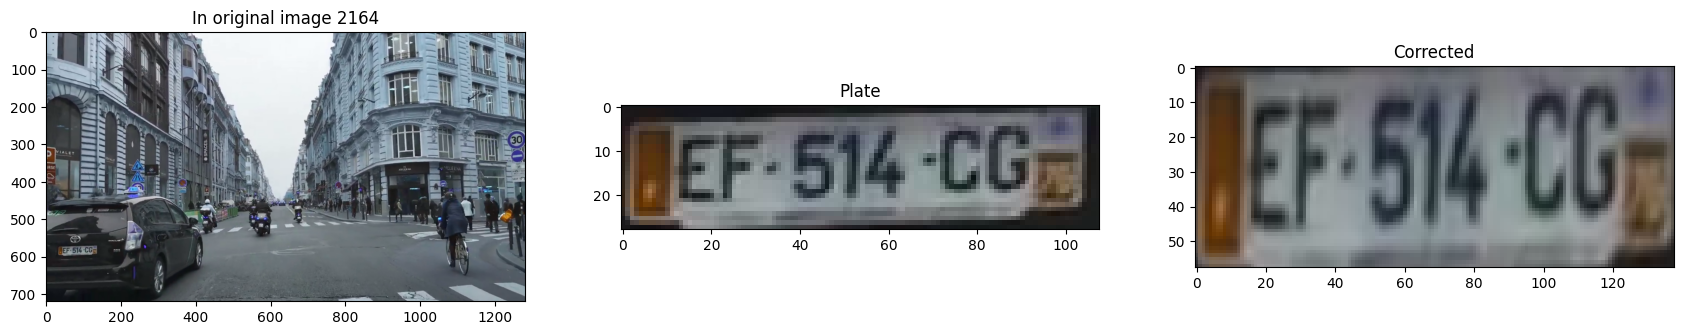

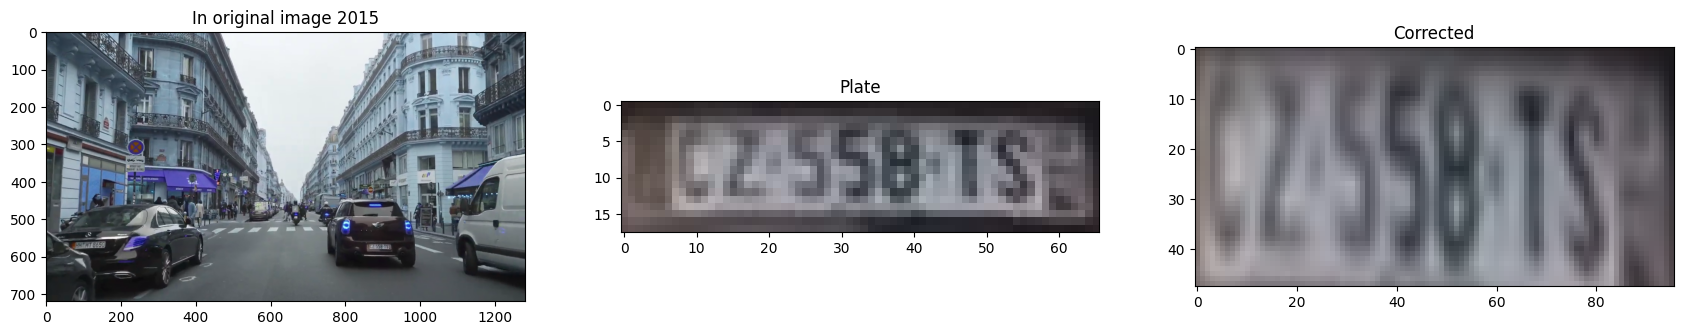

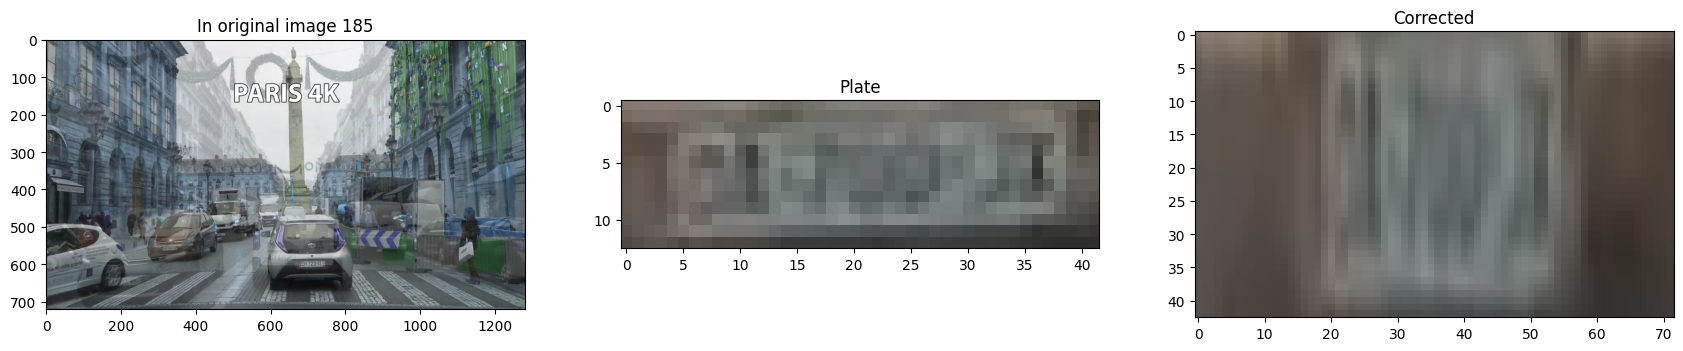

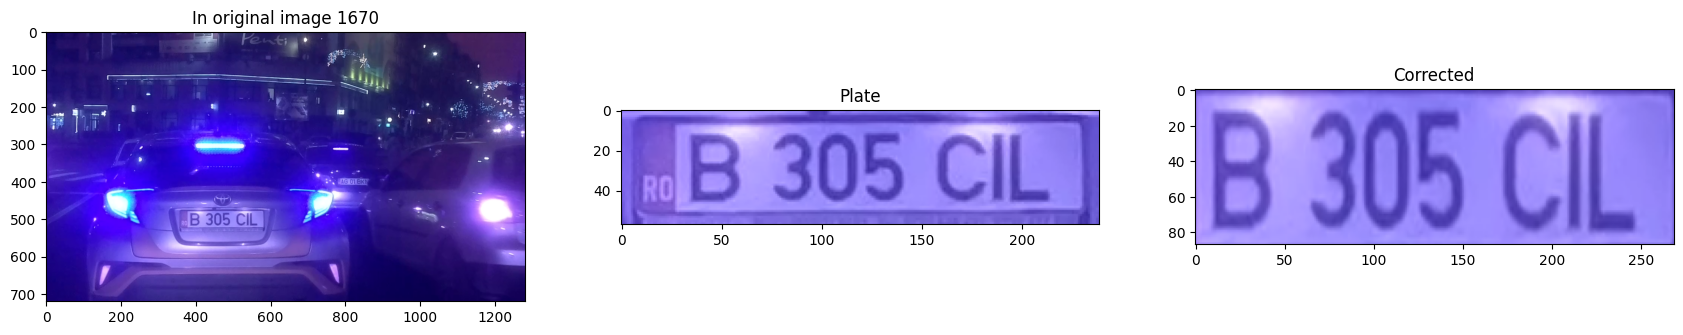

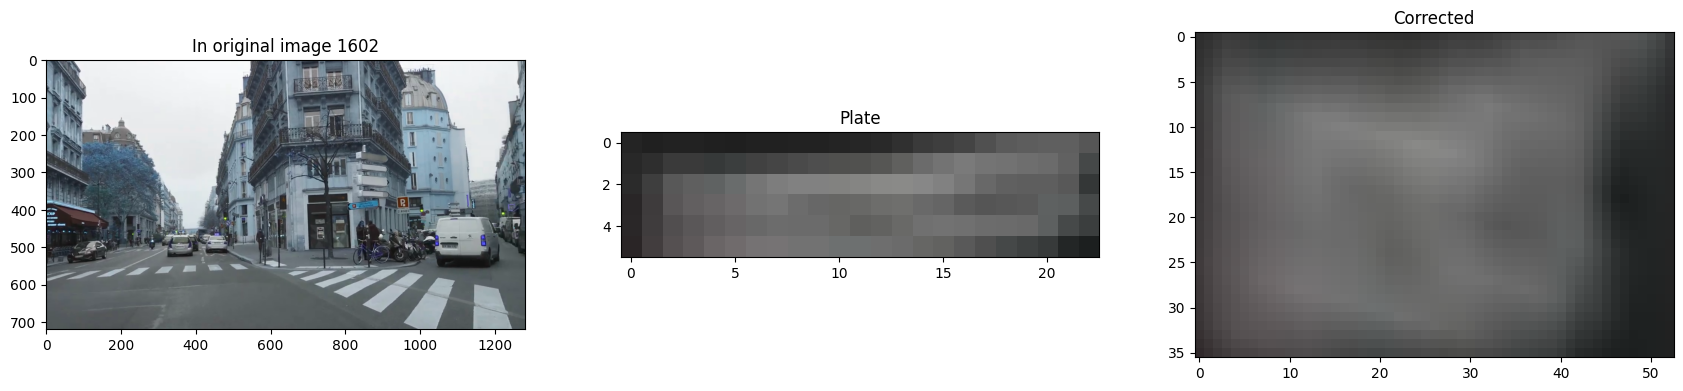

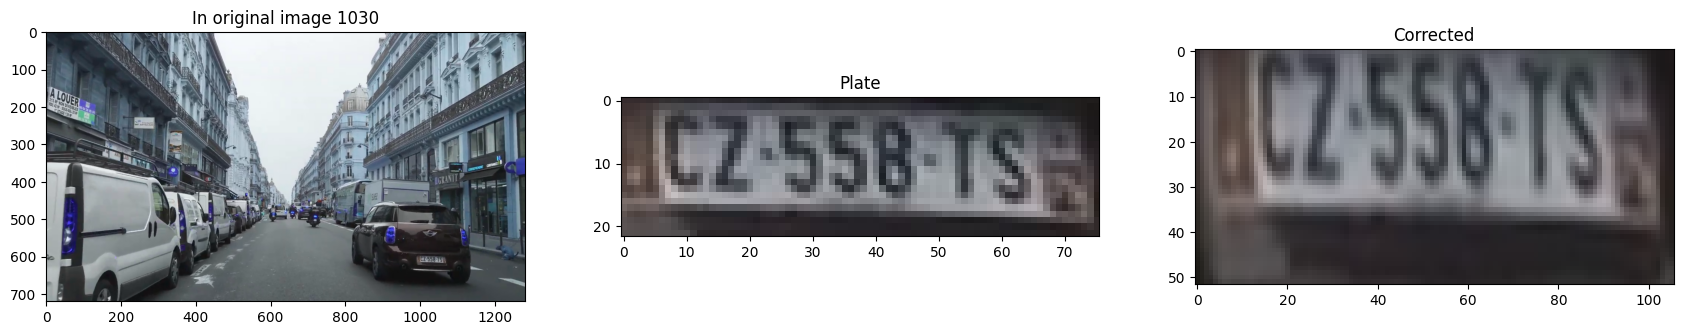

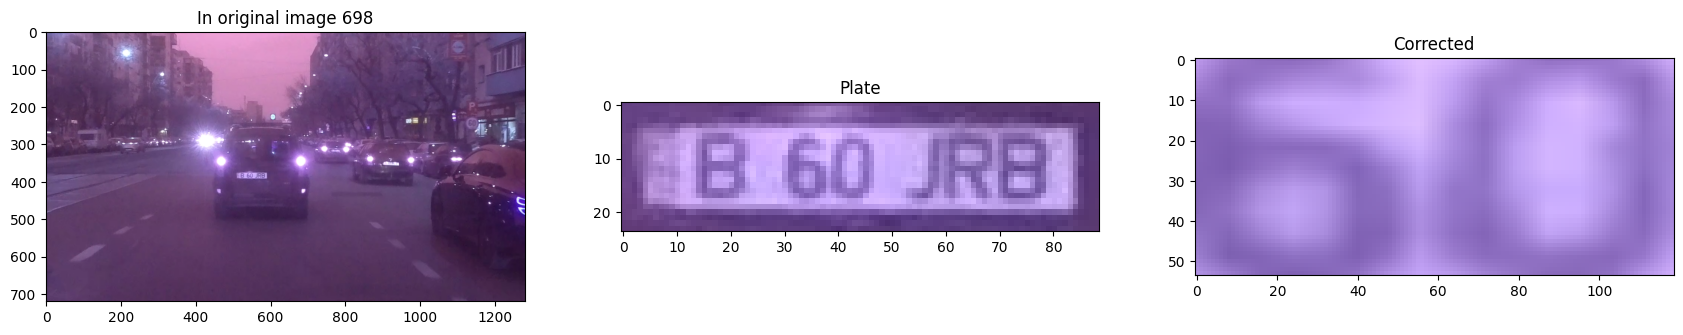

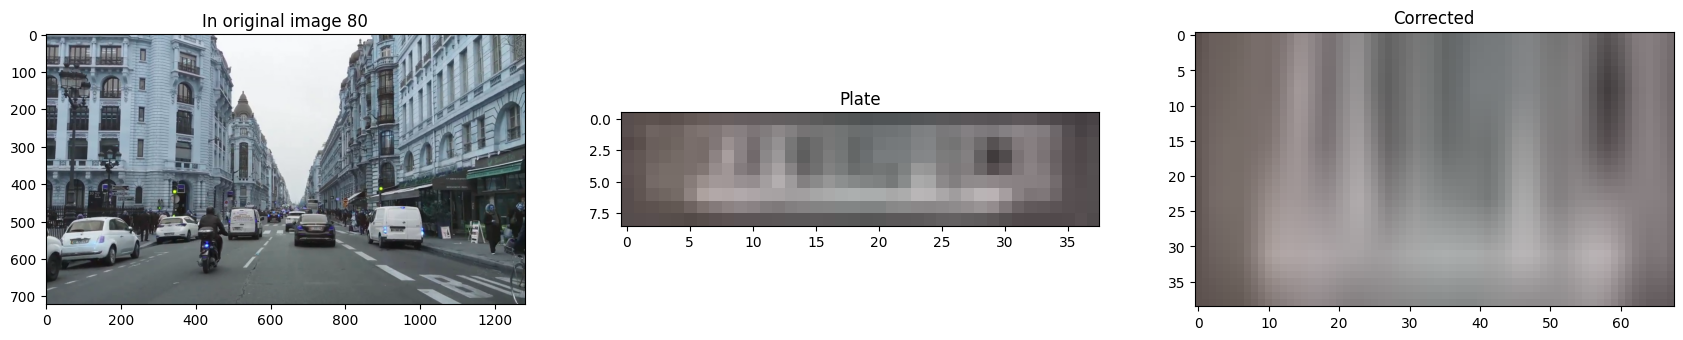

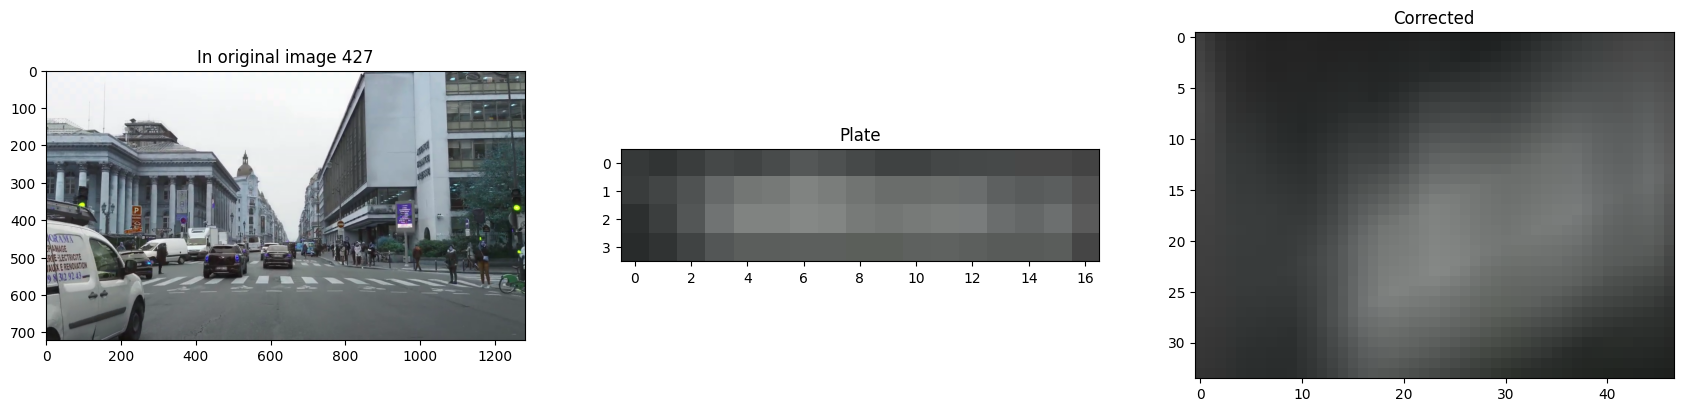

In [14]:
from alprLib.Perspective import platePerspectiveUnwarpingWithWhite
from alprLib.Perspective import platePerspectiveUnwarpingWithSuperPixel
from alprLib.Perspective import platePerspectiveUnwarping

image_indices = rd.choices(np.arange(len(raw_imgs)-1), k=20)
uncorrected_images = []
corrected_images = []

images_image_gray = []
images_seg = []
images_image_polycontours = []
images_image_contour = []

anno_images = []
for index in image_indices:
	start = time.time()

	wholeimage = raw_imgs[index]
	plate = annotations[index]
	
	# corrected = platePerspectiveUnwarpingWithWhite(
	# 	wholeimage, plate.xmin, plate.ymin, plate.xmax, plate.ymax
	# )

	# corrected = platePerspectiveUnwarpingWithSuperPixel(
	#   wholeimage, plate.xmin, plate.ymin, plate.xmax, plate.ymax,
	#   plate_padding = 15,
	#   main_color = np.array([200,200,200]),
	#   color_dist = 150
	# )

	corrected = platePerspectiveUnwarping(
	  wholeimage, plate.xmin, plate.ymin, plate.xmax, plate.ymax,
	  plate_padding=15
	)

	end = time.time()
	elapsed = end - start
	print(f"image {index}: {elapsed} seconds")

	corrected_images.append(corrected)
	uncorrected_images.append(wholeimage)
	anno_images.append(plate)

for i in range(len(corrected_images)):
	fig, axisarray = plt.subplots(1, 3, figsize=(21,8))
	plate = anno_images[i]
	axisarray[0].set_title(f"In original image {image_indices[i]}")
	axisarray[0].imshow(uncorrected_images[i])
	axisarray[1].set_title('Plate')
	axisarray[1].imshow(uncorrected_images[i][plate.ymin:plate.ymax, plate.xmin:plate.xmax])
	axisarray[2].set_title('Corrected')
	axisarray[2].imshow(corrected_images[i])
